In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

In [0]:
# Creating and converting dataset to tensorflow
path = tf.keras.utils.get_file('dracula.txt', 'http://www.gutenberg.org/cache/epub/345/pg345.txt')
text = open(path, 'rb').read().decode(encoding='utf-8')
vocabulary = sorted(set(text))
vocabulary_size = len(vocabulary)

In [10]:
# map unique characters to indices and vice versa
charMapping = {u:i for i, u in enumerate(vocabulary)}
indiceMapping = np.array(vocabulary)
text_as_int = np.array([charMapping[c] for c in text])

sequence_length = 100
examples_per_epoch = len(text)//sequence_length # floor division
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(sequence_length+1, drop_remainder=True)

num_of_characters = len(text)
num_of_vocabulary = len(vocabulary)
print("Total Characters: ", num_of_characters)
print("Total Vocabulary: ", num_of_vocabulary)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Total Characters:  883114
Total Vocabulary:  102


In [0]:
BATCH_SIZE = 512
steps_per_epoch = examples_per_epoch//BATCH_SIZE # floor division
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [0]:
# Build model
embedding_dimension = 256
rnn_units = 1024

lstm = tf.keras.layers.CuDNNLSTM # fast LSTM implementation backed by cuDNN

def build_model(vocab_size, embedding_dim, units, batch_size, drop_out):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]), # Input layer
    lstm(rnn_units, # Hidden layer 1
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 2
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 3
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 4
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    tf.keras.layers.Dense(vocab_size) # Output layer
  ])
  return model

model = build_model(
  vocab_size = vocabulary_size, 
  embedding_dim=embedding_dimension, 
  units=rnn_units, 
  batch_size=BATCH_SIZE,
  drop_out=0.2)

In [0]:
# Validate the model
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [14]:
# Train the model
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

model.compile(tf.train.AdamOptimizer(), loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS=100
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Prediction shape:  (512, 100, 102)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.624797
Epoch 1/100
17/17 [==============================] - 52s 3s/step - loss: 3.4068
Epoch 2/100
17/17 [==============================] - 48s 3s/step - loss: 3.1799
Epoch 3/100
17/17 [==============================] - 49s 3s/step - loss: 3.1598
Epoch 4/100
17/17 [==============================] - 49s 3s/step - loss: 3.1515
Epoch 5/100
17/17 [==============================] - 49s 3s/step - loss: 3.1458
Epoch 6/100
17/17 [==============================] - 49s 3s/step - loss: 3.1430
Epoch 7/100
17/17 [==============================] - 49s 3s/step - loss: 3.1413
Epoch 8/100
17/17 [==============================] - 49s 3s/step - loss: 3.1396
Epoch 9/100
17/17 [==============================] - 49s 3s/step - loss: 3.1387
Epoch 10/100
17/17 [==============================] - 49s 3s/step - loss: 3.1383
Epoch 11/100
17/17 [==============================] - 49s 3s/step - loss: 3.1372
Epoch 12/1

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocabulary_size, embedding_dimension, rnn_units, batch_size=1, drop_out=0.2)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
# Generate text algorithm
def generate_text(model, num_char_to_generate, temperature, start_string):
  # Converting our start string to numbers (vectorizing) 
  input_eval = [charMapping[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  for i in range(num_char_to_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(indiceMapping[predicted_id])

  return (start_string + ''.join(text_generated))

In [17]:
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.

print(generate_text(model, 5000, .6, "Dracula moved to Copenhagen because "))

Instructions for updating:
Use tf.random.categorical instead.
Dracula moved to Copenhagen because he would be to
see me when he had been able to give the conversation that may be
some of them which seem to make the great boxes of the first time. When the
door was began to do as the light of the dogs are more
lesson in the edge of the next day, and then, if I may." I asked my dear old
of what had been. I suppose it is the room with some strange things that have
tried to see her present for us, but there is some kind of the great
lart--have to be good end. When I had done the men says. Some of these grim burst of the way." I thought I could not have
taken with me, and let them say for the same time the words I would broke the house she
speak on the ground and himself find this time they would be feeling out of the gate we cannot get
into the room and the bad confidence. The air was spoken in the castle by
the coming of the same time. We must tell you it will be a word to his hand on the 

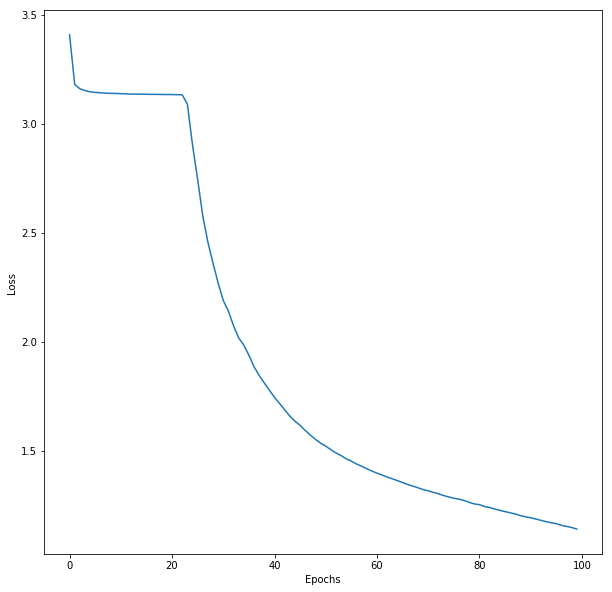

In [18]:
import matplotlib.pyplot as plt
import numpy as np
loss = history.history['loss']
newLoss = np.squeeze(loss)
plt.figure(figsize=(10,10))
plt.plot(newLoss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()